In [1]:
from dotenv import load_dotenv
import os

import sqlite3
import asyncio
import aiosqlite

from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langchain_core.tools import tool
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_ollama import ChatOllama

In [2]:
load_dotenv("../chatbot/.env")

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "llama3.2-calculator"

## Create tools

In [4]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

@tool
def subtract(a:int, b:int) -> float:
    """subtract a and b.

    Args:
        a: first int
        b: second int
    """
    return a-b

In [5]:
tools = [add, multiply, divide, subtract]

In [6]:
model = ChatOllama(model="llama3.2", temperature=0)
model_with_tools = model.bind_tools(tools)

## streaming token works well if no tool binding

In [7]:
# Graph
builder = StateGraph(MessagesState)
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")
def assistant(state: MessagesState, config):
   message = [sys_msg] + state["messages"]
   model_response = model.invoke(
       message,
        config )
   return {"messages": model_response}


builder.add_node("assistant", assistant)
builder.add_edge("assistant", END)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")

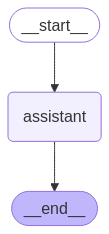

Here|'s| a| short| poem| I| came| up| with|:

Numbers| dance| in| my| mind|,
 of| digits| aligned|.
 too|,and| subtract|,| multiply|
|The| rhythm| of| math|,| forever| true|.

In| the| realm| of| numbers|,| I| roam| free|,
Where| |2| +| |2| equals| harmony|.
 beauty| of| math|,| it| never| fades|,
 that|'s| universal|,| in| every| shade|.

 to| decimals|,| I| explore|,
,| and| all| its| score|.
 reason|,| I| play|,
,| every| single| day|.||

In [8]:
config = {"configurable": {"thread_id": "no-tool"}}
async with AsyncSqliteSaver.from_conn_string("checkpoints.db") as memory:
    react_graph = builder.compile(checkpointer=memory)
    display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))
    async for event in react_graph.astream_events({"messages": [HumanMessage(content="write me a poem?")]}, 
                                                   config, version="v2", stream_mode="messages"):
  
        if event["metadata"].get("langgraph_node", "") == "assistant":
            if event["event"] == "on_chat_model_stream":
                data = event["data"]
                print(data["chunk"].content, end="|")

## streaming token doesn't work with tool binding 

In [9]:
# Graph
config = {"configurable": {"thread_id": "with-tool"}}
builder = StateGraph(MessagesState)
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")
def assistant(state: MessagesState, config):
   message = [sys_msg] + state["messages"]
   model_response = model_with_tools.invoke(
       message,
        config )
   return {"messages": model_response}

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

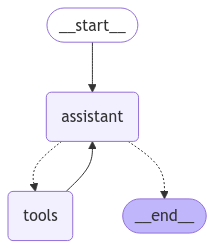

||The result of the expression 1 + 2 * 5 + 100 is 107.|

In [10]:
async with AsyncSqliteSaver.from_conn_string("checkpoints.db") as memory:
    react_graph = builder.compile(checkpointer=memory)
    display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))
    async for event in react_graph.astream_events({"messages": [HumanMessage(content="what is 1+2*5+100?")]}, 
                                                   config, version="v2", stream_mode="messages"):
  
        if event["metadata"].get("langgraph_node", "") == "assistant":
            if event["event"] == "on_chat_model_stream":
                data = event["data"]
                print(data["chunk"].content, end="|")
                print(data["ch

## Check history 

In [11]:
config = {"configurable": {"thread_id": "no-tool"}}
async with AsyncSqliteSaver.from_conn_string("checkpoints.db") as memory:
    result = await memory.aget_tuple(config)
    print(result)

CheckpointTuple(config={'configurable': {'thread_id': 'no-tool', 'checkpoint_ns': '', 'checkpoint_id': '1eff7b87-86a6-6836-8001-c8c0cfad1196'}}, checkpoint={'v': 1, 'ts': '2025-03-02T22:48:33.805681+00:00', 'id': '1eff7b87-86a6-6836-8001-c8c0cfad1196', 'channel_values': {'messages': [HumanMessage(content='write me a poem?', additional_kwargs={}, response_metadata={}, id='b2454975-899c-484e-b02f-235debfd2d3a'), AIMessage(content="Here's a short poem I came up with:\n\nNumbers dance in my mind,\nA symphony of digits aligned.\nAdd and subtract, multiply too,\nThe rhythm of math, forever true.\n\nIn the realm of numbers, I roam free,\nWhere 2 + 2 equals harmony.\nThe beauty of math, it never fades,\nA language that's universal, in every shade.\n\nFrom fractions to decimals, I explore,\nThe world of numbers, and all its score.\nI calculate, I reason, I play,\nIn the game of math, every single day.", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-03-02T22:4

In [54]:
config = {"configurable": {"thread_id": "with-tool"}}
async with AsyncSqliteSaver.from_conn_string("checkpoints.db") as memory:
    result = await memory.aget_tuple(config)
    print(result)

CheckpointTuple(config={'configurable': {'thread_id': 'with-tool', 'checkpoint_ns': '', 'checkpoint_id': '1eff7b8b-36b2-6b00-8008-15b11a6284a8'}}, checkpoint={'v': 1, 'ts': '2025-03-02T22:50:12.796219+00:00', 'id': '1eff7b8b-36b2-6b00-8008-15b11a6284a8', 'channel_values': {'messages': [HumanMessage(content='what is 1+2*5+100?', additional_kwargs={}, response_metadata={}, id='00052d4b-116c-448e-af07-a2b728010fef'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-03-02T22:48:43.103775Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1491490625, 'load_duration': 38013625, 'prompt_eval_count': 414, 'prompt_eval_duration': 1005000000, 'eval_count': 22, 'eval_duration': 446000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-5ea72cee-84de-4be8-9476-e4a935cae336', tool_calls=[{'name': 'add', 'args': {'a': 7, 'b': 100}, 'id': '8527c5a3-23e8-4bdc-bb1b-9e1f5395d5f8', 'type': 'tool_ca

## Tool with breakpoints:

* Approval
* Debugging
* Editing 

## Approval 

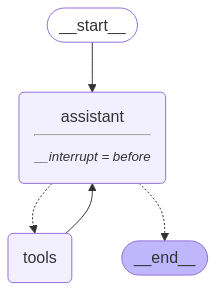

In [88]:
from IPython.display import Image, display

from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.sqlite import SqliteSaver

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [model_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

db_path = "checkpoints.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [89]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "103"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [90]:
state = graph.get_state_history(thread)

In [91]:
all_states = [s for s in state]

In [93]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (79a9a3b2-1f84-4248-8f79-c6de6fa5c8b1)
 Call ID: 79a9a3b2-1f84-4248-8f79-c6de6fa5c8b1
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [98]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "100"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# user_approval = input("Do you want to call the tool? (yes/no):")

# if user_approval.lower() == "yes":
#     for event in graph.stream(None, thread, stream_mode="values"):
#         event["messages"][-1].pretty_print()
# else:
#     print(graph.get_state(thread).next)
#     print("Operation cancelledby user.")

================================ Human Message =================================

Multiply 2 and 3


In [99]:
graph.get_state(thread).next

('assistant',)

## update states

In [95]:
graph.update_state(
    thread,
    {"messages":[HumanMessage(content="No, actually multiple 3 and 4!")]}
)

{'configurable': {'thread_id': '100',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff95a6-6f78-61a8-8008-7c9dfb27d23a'}}

In [96]:
new_state = graph.get_state(thread).values
for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (a0e57a63-e392-4993-9c82-bdd58a5f159b)
 Call ID: a0e57a63-e392-4993-9c82-bdd58a5f159b
  Args:
    a: 2
    b: 3
================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (16abe2e6-63ca-48ed-a770-8e557fcab4ee)
 Call ID: 16abe2e6-63ca-48ed-a770-8e557fcab4ee
  Args:
    a: 2
    b: 3
================================ Human Message =================================

No, actually multiple 3 and 4!
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiple 3 and 4!


In [97]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiple 3 and 4!
================================== Ai Message ==================================
Tool Calls:
  multiply (5904c811-c2a8-4cbe-a88e-f4196f3de291)
 Call ID: 5904c811-c2a8-4cbe-a88e-f4196f3de291
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12


## Time Travel

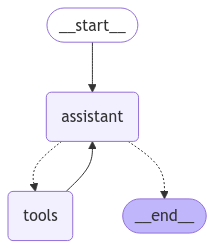

In [100]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [model_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [102]:

initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (9cab18b1-2bde-4649-88d1-ba3b09a89a1c)
 Call ID: 9cab18b1-2bde-4649-88d1-ba3b09a89a1c
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [106]:
all_states = [s for s in graph.get_state_history(thread)]

In [108]:
len(all_states)

5

In [114]:
all_states[-1].parent_config

## Replay

In [116]:
to_replay = all_states[-2]
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='e7795a64-ea10-44c5-87f1-643c455d78d0')]}

In [118]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff95bb-e009-6a92-8000-03b0abb486e3'}}

In [120]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (b5e2a71c-05ce-4735-aac1-35a4513c58d4)
 Call ID: b5e2a71c-05ce-4735-aac1-35a4513c58d4
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Forking 

In [121]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='e7795a64-ea10-44c5-87f1-643c455d78d0')]

In [122]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff95bb-e009-6a92-8000-03b0abb486e3'}}

In [123]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages":[HumanMessage(content="Divide 256 by 16", id=to_fork.values["messages"][0].id)]},
)

In [124]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1effa228-ba05-6d7c-8001-092938dccb1a'}}

In [125]:
all_states = [state for state in graph.get_state_history(thread)]
all_states[0].values["messages"]

[HumanMessage(content='Divide 256 by 16', additional_kwargs={}, response_metadata={}, id='e7795a64-ea10-44c5-87f1-643c455d78d0')]

In [127]:
graph.get_state({"configurable": {"thread_id": "1"}})

StateSnapshot(values={'messages': [HumanMessage(content='Divide 256 by 16', additional_kwargs={}, response_metadata={}, id='e7795a64-ea10-44c5-87f1-643c455d78d0')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1effa228-ba05-6d7c-8001-092938dccb1a'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Divide 256 by 16', additional_kwargs={}, response_metadata={}, id='e7795a64-ea10-44c5-87f1-643c455d78d0')]}}, 'thread_id': '1', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1eff95bb-e009-6a92-8000-03b0abb486e3'}, created_at='2025-03-06T00:32:55.014919+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1eff95bb-e009-6a92-8000-03b0abb486e3'}}, tasks=(PregelTask(id='81dc1b3e-6b2d-528d-5428-9a11af110ade', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [128]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Divide 256 by 16
================================== Ai Message ==================================
Tool Calls:
  divide (f20f7c97-9f1a-4d5a-a158-17eb54964c06)
 Call ID: f20f7c97-9f1a-4d5a-a158-17eb54964c06
  Args:
    a: 256
    b: 16
================================= Tool Message =================================
Name: divide

16.0
================================== Ai Message ==================================

The result of dividing 256 by 16 is 16.


In [138]:
graph.get_state({"configurable": {"thread_id":"1"}}).values["messages"][-1]

AIMessage(content='The result of dividing 256 by 16 is 16.', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-03-06T00:35:50.706945Z', 'done': True, 'done_reason': 'stop', 'total_duration': 406039500, 'load_duration': 15202166, 'prompt_eval_count': 110, 'prompt_eval_duration': 132000000, 'eval_count': 14, 'eval_duration': 256000000, 'message': {'role': 'assistant', 'content': 'The result of dividing 256 by 16 is 16.', 'images': None, 'tool_calls': None}}, id='run-90fb9744-bd8a-455e-9e15-29c5214da323-0', usage_metadata={'input_tokens': 110, 'output_tokens': 14, 'total_tokens': 124})